# Brownian Motion (Wiener Process)

Brownian motion, also known as the Wiener process, is a continuous-time stochastic process named after botanist Robert Brown. It is a fundamental concept in mathematics, physics, and finance (e.g., the Black-Scholes model).

## Theory

A standard Brownian motion $W(t)$ is characterized by the following properties:

1. **Start at zero:** $W(0) = 0$.
2. **Continuous paths:** The function $t \mapsto W(t)$ is continuous almost surely.
3. **Independent increments:** For $0 \le t_1 < t_2 < \dots < t_n$, the increments $W(t_2)-W(t_1), \dots, W(t_n)-W(t_{n-1})$ are independent.
4. **Gaussian increments:** The increment $W(t+dt) - W(t)$ is normally distributed with mean 0 and variance $dt$: 
   $$W(t+dt) - W(t) \sim \mathcal{N}(0, dt)$$

### General Brownian Motion
A general Brownian motion $X(t)$ with drift $\mu$ and volatility $\sigma$ can be described by the Stochastic Differential Equation (SDE):
$$ dX(t) = \mu dt + \sigma dW(t) $$

The solution is given by:
$$ X(t) = X(0) + \mu t + \sigma W(t) $$

Where $X(t) \sim \mathcal{N}(X(0) + \mu t, \sigma^2 t)$.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from typing import Tuple, List, Optional

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')

## Implementation

We implement a `BrownianMotion` class to simulate paths and analyze the distribution.

In [3]:
class BrownianMotion:
    def __init__(self, x0: float = 0, mu: float = 0, sigma: float = 1, dt: float = 0.01):
        """
        Initialize Brownian Motion parameters.
        
        Args:
            x0: Initial value
            mu: Drift coeffcient
            sigma: Diffusion coefficient (volatility)
            dt: Time step size
        """
        self.x0 = x0
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        
    def simulate_path(self, n_steps: int) -> Tuple[np.ndarray, np.ndarray]:
        """
        Simulate a single path of Brownian Motion.
        
        Args:
            n_steps: Number of time steps to simulate
            
        Returns:
            Tuple of (time_array, path_array)
        """
        # Generate random increments: dW ~ N(0, dt)
        # dX = mu*dt + sigma*dW
        dW = np.random.normal(0, np.sqrt(self.dt), n_steps)
        dX = self.mu * self.dt + self.sigma * dW
        
        # Set starting position (increments start from index 1 in cumsum effectively)
        # To define path[0] = x0, we prepend x0 and compute cumsum of increments
        path = np.zeros(n_steps + 1)
        path[0] = self.x0
        path[1:] = self.x0 + np.cumsum(dX)
        
        t = np.linspace(0, n_steps * self.dt, n_steps + 1)
        return t, path
    
    def simulate_distribution(self, n_samples: int, t_target: float) -> np.ndarray:
        """
        Simulate the distribution of values at a specific time t.
        
        Args:
            n_samples: Number of paths to simulate
            t_target: Target time to check distribution
            
        Returns:
            Array of final values at t_target
        """
        n_steps = int(t_target / self.dt)
        # Vectorized simulation for end points
        # X(t) ~ N(x0 + mu*t, sigma^2 * t)
        # We can implement this simply by summing N random variables
        # Or simulating full paths if we wanted mid-points, but for endpoint:
        
        # Direct simulation of N independent paths' endpoints:
        # Total variance for t_target is sigma^2 * t_target
        # Total drift is mu * t_target
        # We can simulate step-by-step or just sample from the known distribution.
        # To be true to "simulation" of the process, we should simulate the sum of steps.
        
        # Sum of n_steps independent N(mu*dt, sigma^2*dt)
        increments = np.random.normal(
            self.mu * self.dt, 
            self.sigma * np.sqrt(self.dt), 
            (n_samples, n_steps)
        )
        final_values = self.x0 + np.sum(increments, axis=1)
        return final_values

## Visualization

Let's visualize sample paths and the distribution at a terminal time.

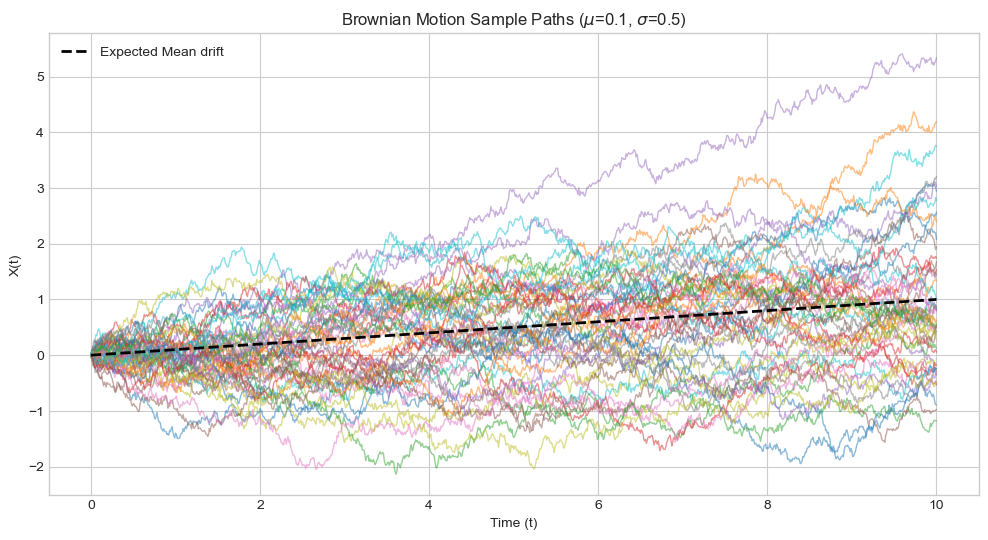

In [4]:
# Parameters
mu = 0.1
sigma = 0.5
x0 = 0
dt = 0.01
t_max = 10
n_steps = int(t_max / dt)
n_paths = 50

# Create instance
bm = BrownianMotion(x0=x0, mu=mu, sigma=sigma, dt=dt)

# Plot Sample Paths
plt.figure(figsize=(12, 6))
for i in range(n_paths):
    t, path = bm.simulate_path(n_steps)
    plt.plot(t, path, alpha=0.5, linewidth=1)
    
plt.title(f'Brownian Motion Sample Paths ($\mu$={mu}, $\sigma$={sigma})')
plt.xlabel('Time (t)')
plt.ylabel('X(t)')
plt.plot(t, x0 + mu * t, 'k--', label='Expected Mean drift', linewidth=2)
plt.legend()
plt.show()

### Distribution Analysis

We verify that the distribution of $X(t)$ at a certain time $T$ follows the theoretical normal distribution:
$$ X(T) \sim \mathcal{N}(x_0 + \mu T, \sigma^2 T) $$

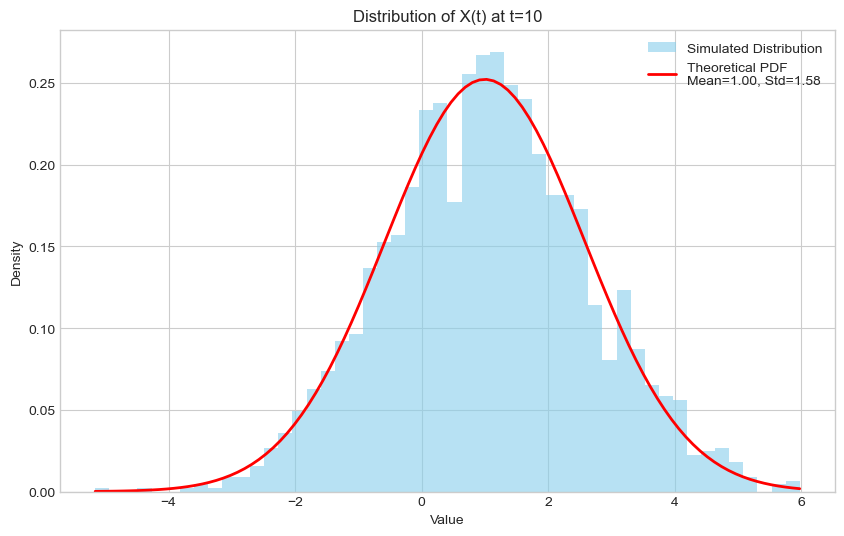

In [5]:
# Simulate distribution at t_max
n_samples = 2000
final_values = bm.simulate_distribution(n_samples, t_max)

# Plot Histogram
plt.figure(figsize=(10, 6))
count, bins, ignored = plt.hist(final_values, 50, density=True, alpha=0.6, color='skyblue', label='Simulated Distribution')

# Plot Theoretical PDF
theoretical_mean = x0 + mu * t_max
theoretical_std = sigma * np.sqrt(t_max)
x = np.linspace(min(final_values), max(final_values), 100)
pdf = stats.norm.pdf(x, theoretical_mean, theoretical_std)

plt.plot(x, pdf, 'r-', linewidth=2, label=f'Theoretical PDF\nMean={theoretical_mean:.2f}, Std={theoretical_std:.2f}')
plt.title(f'Distribution of X(t) at t={t_max}')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

## Quadratic Variation

One of the most fundamental properties of Brownian motion is that its paths are nowhere differentiable. This is closely related to the concept of **Quadratic Variation**.

For a partition of the time interval $[0, T]$ with step size $\Delta t$, the quadratic variation is defined as:
$$ [W, W](T) = \lim_{\Delta t \to 0} \sum (W(t_{i+1}) - W(t_i))^2 $$

Unlike smooth functions where this sum converges to 0, for Brownian motion, it converges to $T$ (almost surely). This implies:
$$ (dW)^2 = dt $$

Let's verify this computationally.

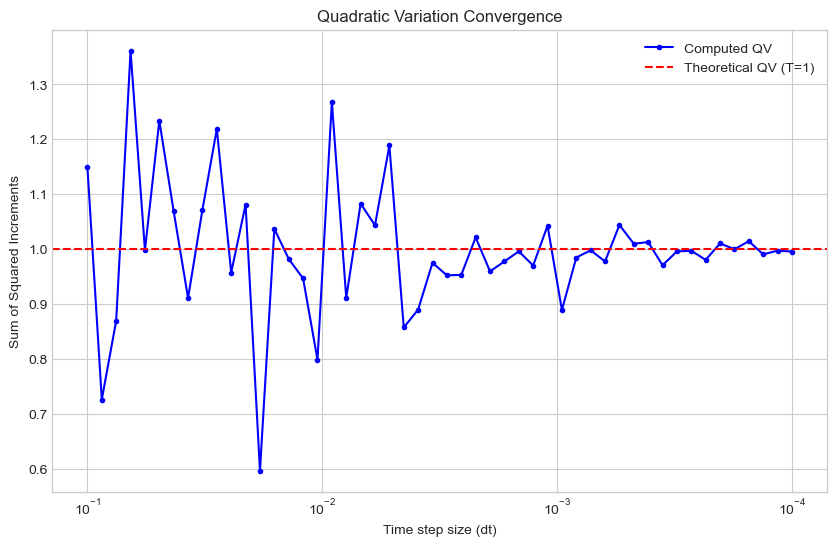

In [6]:
def quadratic_variation(dt_values, T=1.0):
    """Compute quadratic variation for different time steps dt."""
    qv_results = []
    
    for dt in dt_values:
        n = int(T / dt)
        # Simulate standard Brownian increments
        dW = np.random.normal(0, np.sqrt(dt), n)
        # Sum of squared increments
        qv = np.sum(dW**2)
        qv_results.append(qv)
        
    return qv_results

# Different step sizes (decreasing)
dt_values = np.logspace(-1, -4, 50)
qv_values = quadratic_variation(dt_values, T=1.0)

plt.figure(figsize=(10, 6))
plt.semilogx(dt_values, qv_values, 'b.-', label='Computed QV')
plt.axhline(y=1.0, color='r', linestyle='--', label='Theoretical QV (T=1)')
plt.title('Quadratic Variation Convergence')
plt.xlabel('Time step size (dt)')
plt.ylabel('Sum of Squared Increments')
plt.legend()
plt.gca().invert_xaxis()  # Invert x-axis to show dt decreasing
plt.show()

## Geometric Brownian Motion (GBM)

Standard Brownian motion can take negative values, which makes it unsuitable for modeling stock prices or population growth. instead, we use **Geometric Brownian Motion (GBM)**.

The SDE for GBM corresponds to the Black-Scholes model:
$$ dS_t = \mu S_t dt + \sigma S_t dW_t $$

Using Itô's Lemma, the exact solution is:
$$ S(t) = S(0) \exp\left( (\mu - \frac{1}{2}\sigma^2)t + \sigma W(t) \right) $$

Key differences:
1. **Multiplicative noise:** Percent changes are independent, not absolute changes.
2. **Log-normal distribution:** $\ln(S_t)$ is normally distributed.
3. **Positivity:** If $S(0) > 0$, then $S(t)$ stays positive.

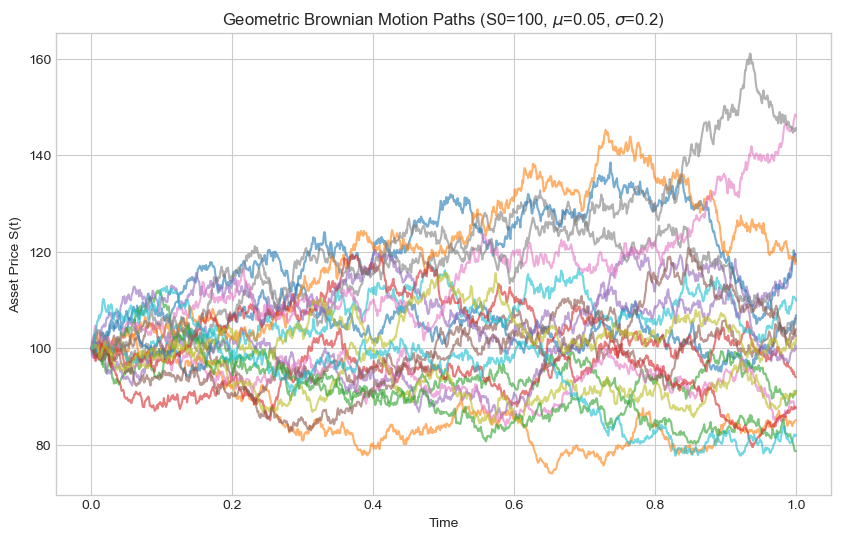

In [7]:
def simulate_gbm(S0, mu, sigma, T, dt, n_paths):
    """Simulate Geometric Brownian Motion paths."""
    n_steps = int(T / dt)
    t = np.linspace(0, T, n_steps + 1)
    
    # Standard Brownian Motion W(t)
    dW = np.random.normal(0, np.sqrt(dt), (n_paths, n_steps))
    W = np.zeros((n_paths, n_steps + 1))
    W[:, 1:] = np.cumsum(dW, axis=1)
    
    # GBM Solution formula
    # Exponent = (mu - 0.5*sigma^2)*t + sigma*W(t)
    # Note: t is a 1D array, broadcasting correctly against W
    exponent = (mu - 0.5 * sigma**2) * t + sigma * W
    S = S0 * np.exp(exponent)
    
    return t, S

# Parameters
S0 = 100
mu = 0.05    # Expected return
sigma = 0.2  # Volatility
T = 1.0
dt = 0.001
n_paths = 20

t, S = simulate_gbm(S0, mu, sigma, T, dt, n_paths)

plt.figure(figsize=(10, 6))
plt.plot(t, S.T, alpha=0.6)
plt.title(f'Geometric Brownian Motion Paths (S0={S0}, $\mu$={mu}, $\sigma$={sigma})')
plt.xlabel('Time')
plt.ylabel('Asset Price S(t)')
plt.show()

## Summary

In this notebook, we explored the concept of Brownian Motion, both theoretically and computationally. We:
1. Defined the standard and general Brownian Motion as a stochastic process.
2. Implemented a `BrownianMotion` class to simulate sample paths.
3. Visualized the stochastic nature of the process by plotting multiple paths.
4. Verified the properties of the process by comparing the simulated terminal distribution with the theoretical Normal distribution.
5. Demonstrated the property of **Quadratic Variation**.
6. Introduced **Geometric Brownian Motion (GBM)** used in financial modeling ($S_t > 0$).